Exploring the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None 

Reading data

In [2]:
# Read data

# Portifolio and profile datasets
# portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
# profile = pd.read_json('data/profile.json', orient='records', lines=True)
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile.csv')

# User and offer data, already treated in Data Preparation 
user_offer_df = pd.read_csv('user_offer.csv').astype({'offer_id_rec':np.int8})
# User transactions
user_tra_df = pd.read_csv('user_transactions.csv')

# Reading the hexideciamal to int dictonaries
map_portifolio = json.load(open('mapper_id/portifolio_ids.json'))
map_profile = json.load(open('mapper_id/profile_ids.json'))

Quick look at the data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9


In [4]:
profile.head()

,gender,age,id,became_member_on,income,user_id
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4


In [5]:
user_offer_df.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3
4,4,1.0,0.0,1.09,1.0,NaN,0.0,4


#### Data preparation for analysis

##### 1. Profile

Preparing the profile and portifolio datasets to analysis.  

For the profile dataset, there are some users with a fixed age of 118.   
Observing the other data, it is noted that users who are not registrant such information such as genre, age and income.The only information it appears is when the user became a member.

In [6]:
# For profile, calculate the 

profile.loc[pd.isna(profile['gender'])].head()

,gender,age,id,became_member_on,income,user_id
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,6
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,7


In [7]:
profile.loc[pd.isna(profile.gender)].shape[0] / profile.shape[0]

0.12794117647058822

12% of total users has no data for gender, age and income

To create one more feature for users, the time they are member, in relation to the latest user, since the date of collecting the data is not known.  

It is worth mentioning that even for users without information, this data is present at the dataset

In [8]:
# Convert to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
# Get the newest user in data
most_recent_mem_data = profile['became_member_on'].max()
# Creating a extra column to put number of days compared with newest
profile['rela_member_years'] = ((most_recent_mem_data - profile['became_member_on']).dt.days / 365).round(2)

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,1.45
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2,0.04
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4,0.98


For gender data, the voids are replaced for Not Informed.  
For application in models, this category could be treated separately later

In [9]:
# Replace NaN gender with NI (not informed)
profile['gender'] = profile['gender'].fillna('NI')

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,1.45
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2,0.04
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4,0.98


In [39]:
profile.to_csv('profile2.csv', index=False)

For income, all the users are part of the group that did not also inform the age and gender.  

For this case, the distribution of income to check if the average may be a good choice 

---

In [10]:
# # Tentando regressão linear com as transações

# # profile_income = profile.loc[~(pd.isna(profile['income']))][['user_id', 'income']]
# profile_income = profile[['user_id', 'income']]

# pro_tra_user = profile_income.merge(user_tra_df, left_on='user_id', right_on='person')[['user_id', 'income', 'trans_amount']]

# # To model
# with_income = pro_tra_user.dropna()
# without_income = pro_tra_user.loc[pd.isna(pro_tra_user['income'])]

# # Modeling
# x = with_income[['trans_amount']]
# y = with_income[['income']]

# from sklearn.svm import SVR

# income_model = SVR() #LinearRegression()
# income_model.fit(x,y)
# # income_model.score(x,y)
# # plt.scatter(x,y)
# plt.scatter(y, income_model.predict(x))
# # Predict
# # income_model.predict([[500]])
# # profile.income.map(lambda x: income_model.predict(x) if pd.isna(x) else x)

---

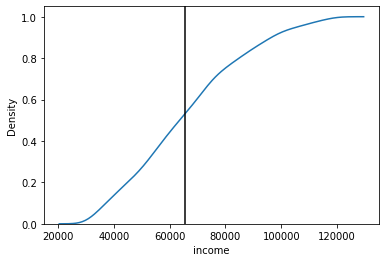

Mean income: 65404.9915682968
Median income: 64000.0


In [11]:
# Distribuition of income
sns.kdeplot(data=profile, x='income', cumulative=True)
plt.axvline(x=profile["income"].mean(), color='black')
plt.show()

print(f'Mean income: {profile["income"].mean()}')
print(f'Median income: {profile["income"].median()}')

65 thousand is the average and 64 thousand the median, which shows that 50% of the values are close to that value.  
Thus, assigning the median to the missing values will not change the distributions significantly.

In [12]:
# Fill na with mean

profile['income'] = profile['income'].fillna(profile.income.median())

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98


Por último, o valor de 118 no campo de idade pode atrapalhar nas análise. Assim, para esses valores, também se usará a mediana das idades como substituto.

In [13]:
# Fill 118 values with meadian, without this extreme value
profile.loc[profile.age == 118, 'age'] = profile.loc[profile.age != 118, 'age'].median()

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98


##### 2. Portifolio

First, create the integer id column for portifolio

In [14]:
# Portifolio

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4


##### 3. Merging datasets

Merging the user offer dataset with profile and portifolio dataset  

The extra information will be used to exploring the data.

In [15]:
# Just interesting columns from profile and portifolio
# Profile
profile2 = profile[['user_id', 'gender', 'age', 'income', 'rela_member_years']]

# Portifolio
portfolio2 = portfolio[['offer_id', 'reward', 'difficulty', 'offer_type']]
portfolio2.columns = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_type']

# Merging with user_offer_id

user_offer_df2 = user_offer_df.merge(portfolio2, left_on='offer_id_rec', right_on='offer_id')
user_offer_df2 = user_offer_df2.merge(profile2, on='user_id')

user_offer_df2.head() 



,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_years
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,1.21
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,1.21
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,1.21
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,1.21
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,0.98


Informações contínuas, como renda e idade podem ser melhor analisadas a partir da sua divisão em partes.  
O melhor agrupamento para uma única variável é nos quartis, separando os dados em 4 partes iguais. Outro agrupamento que permite obersar mais abertamente os valores é a divisão por decils

In [16]:
user_offer_df2['age_quartile'] = pd.qcut(user_offer_df2['age'], q=4)
user_offer_df2['age_decile'] = pd.qcut(user_offer_df2['age'], q=10)
user_offer_df2['income_quartile'] = pd.qcut(user_offer_df2['income'], q=4)
user_offer_df2['income_decile'] = pd.qcut(user_offer_df2['income'], q=10)
user_offer_df2['member_years_quartile'] = pd.qcut(user_offer_df2['rela_member_years'], q=4)

user_offer_df2.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,...,offer_type,gender,age,income,rela_member_years,age_quartile,age_decile,income_quartile,income_decile,member_years_quartile
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,...,informational,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
1,3,1.0,1.0,19.89,1.0,1.0,5.0,3,3,5,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
2,0,1.0,1.0,21.72,1.0,1.0,10.0,3,0,10,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,...,informational,NI,55.0,64000.0,0.98,"(45.0, 55.0]","(54.0, 55.0]","(51000.0, 64000.0]","(61000.0, 64000.0]","(0.57, 0.98]"


#### Exploring the data

By Offer Type

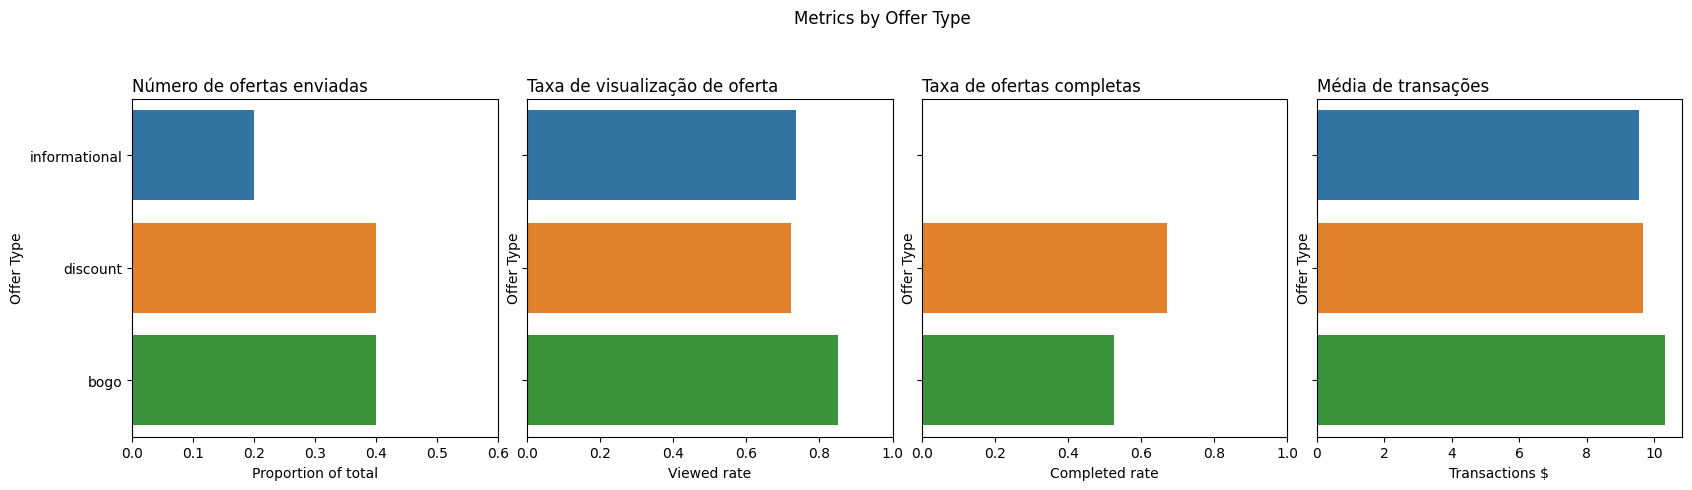

In [17]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, 'offer_type')

By Offer ID

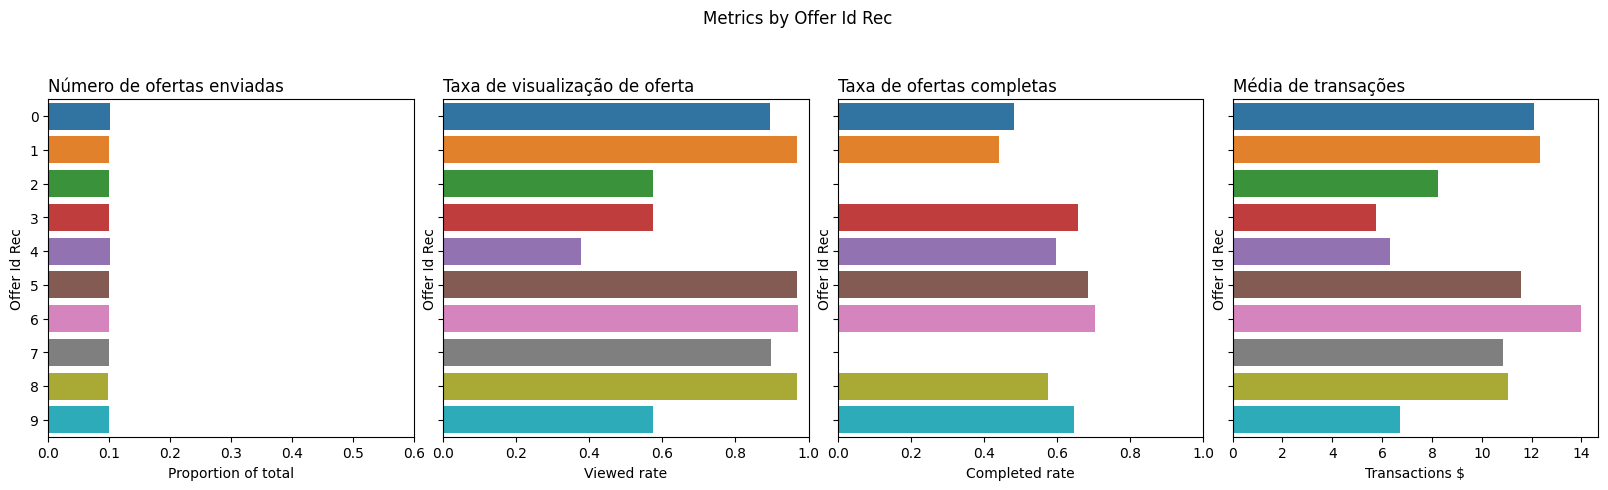

In [18]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, 'offer_id_rec')

By Offer ID and Offer Type

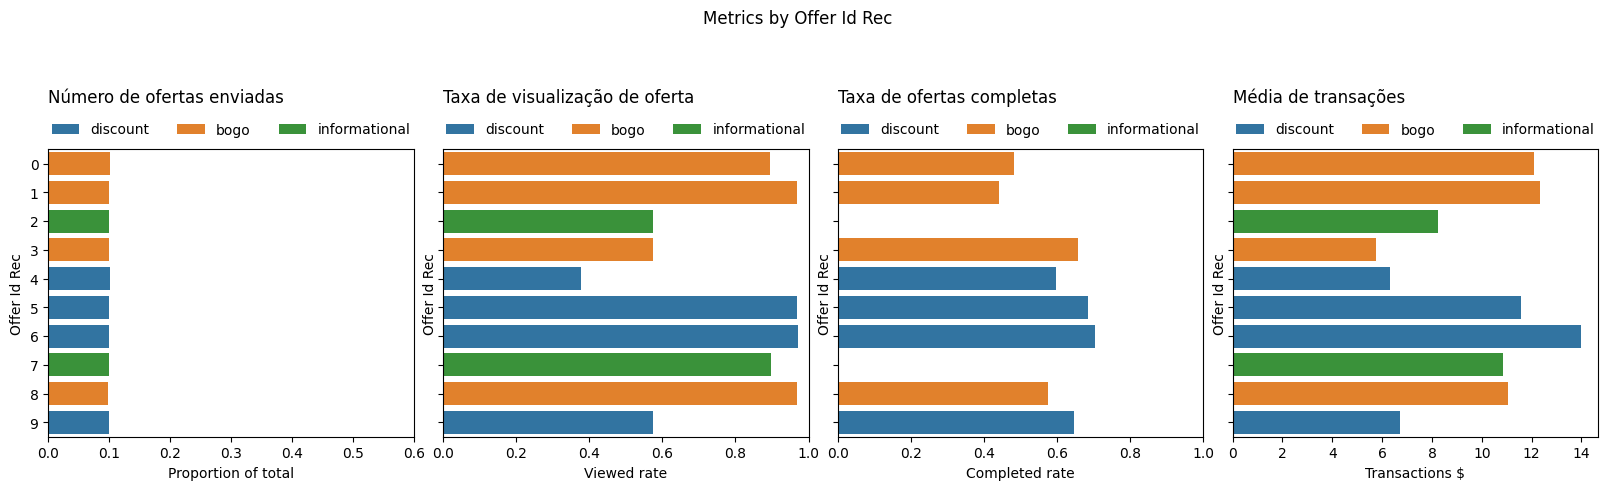

In [19]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, ['offer_id_rec', 'offer_type'])

By Offer Difificulty

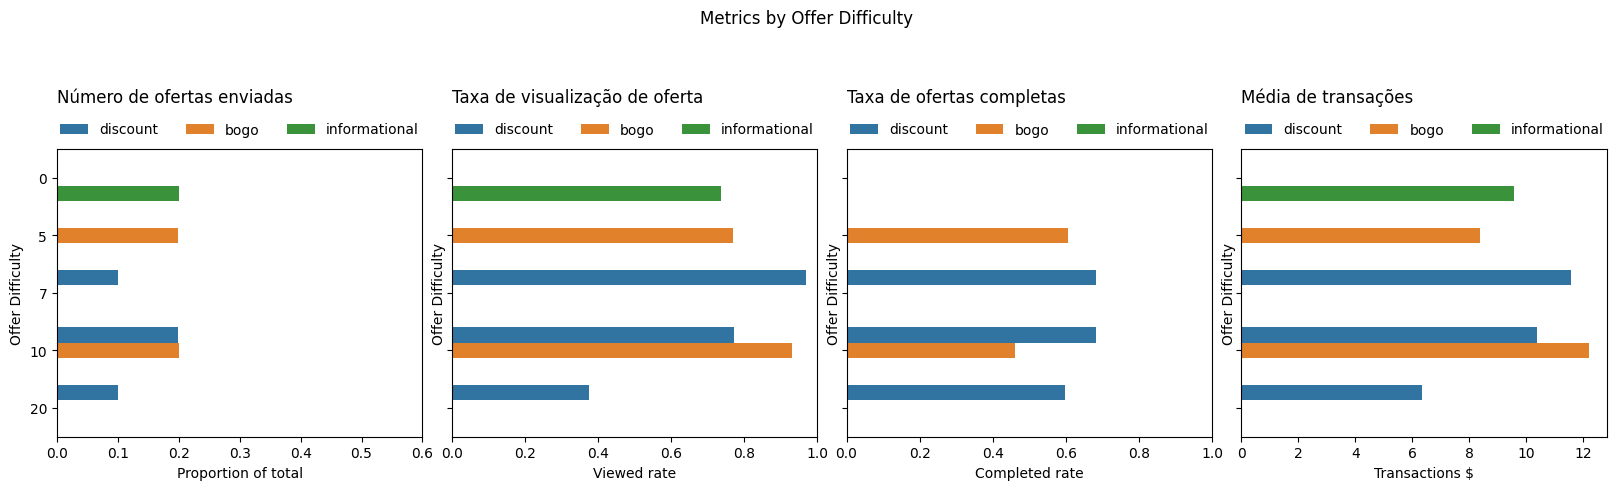

In [20]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, ['offer_difficulty', 'offer_type'], dodge=True)

By Offer Reward

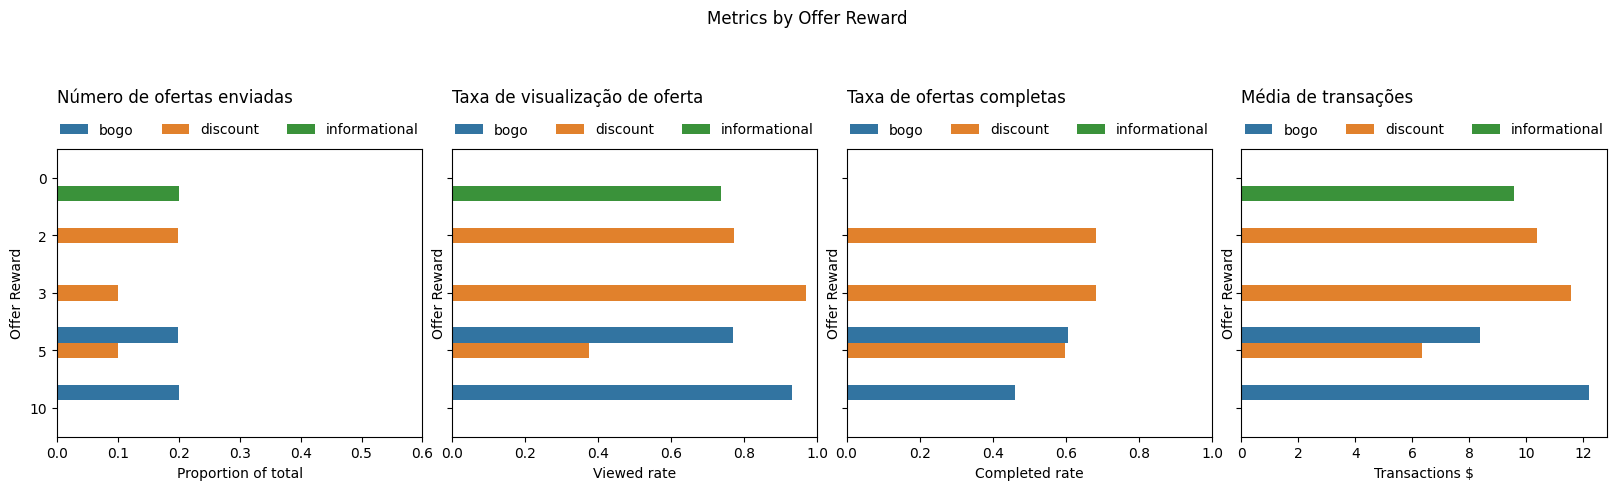

In [21]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, ['offer_reward', 'offer_type'], dodge=True)

By Gender

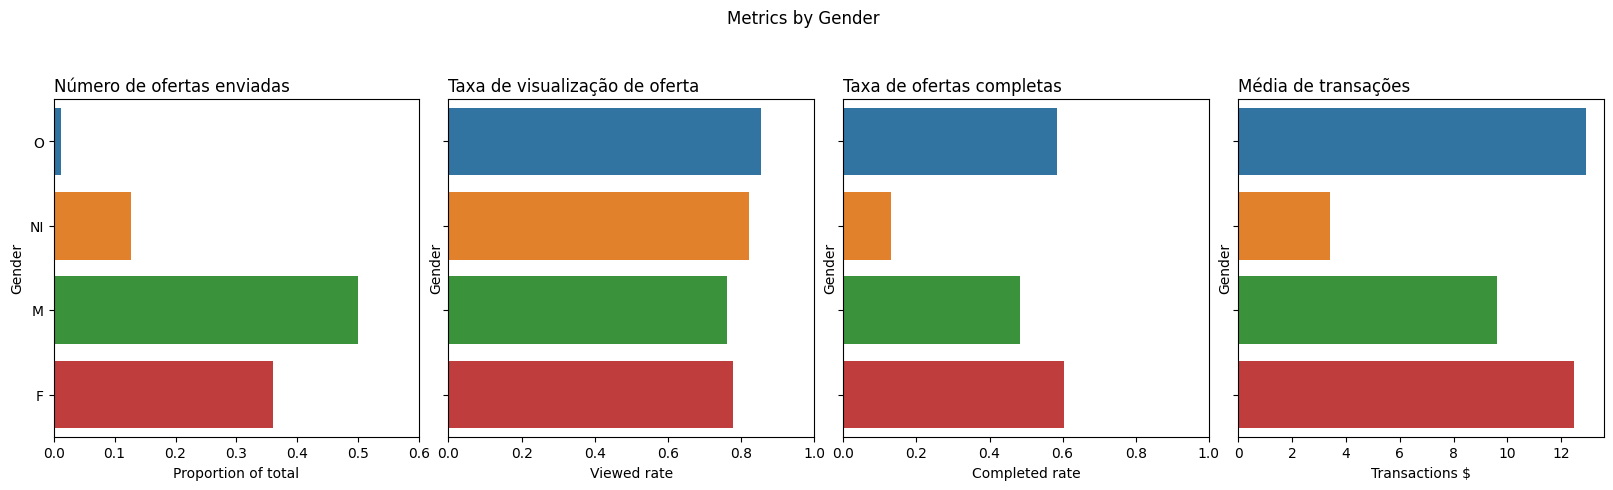

In [22]:
importlib.reload(aux_fun)

aux_fun.plot_grid_metrics(user_offer_df2, 'gender')

By Gender and Offer Type

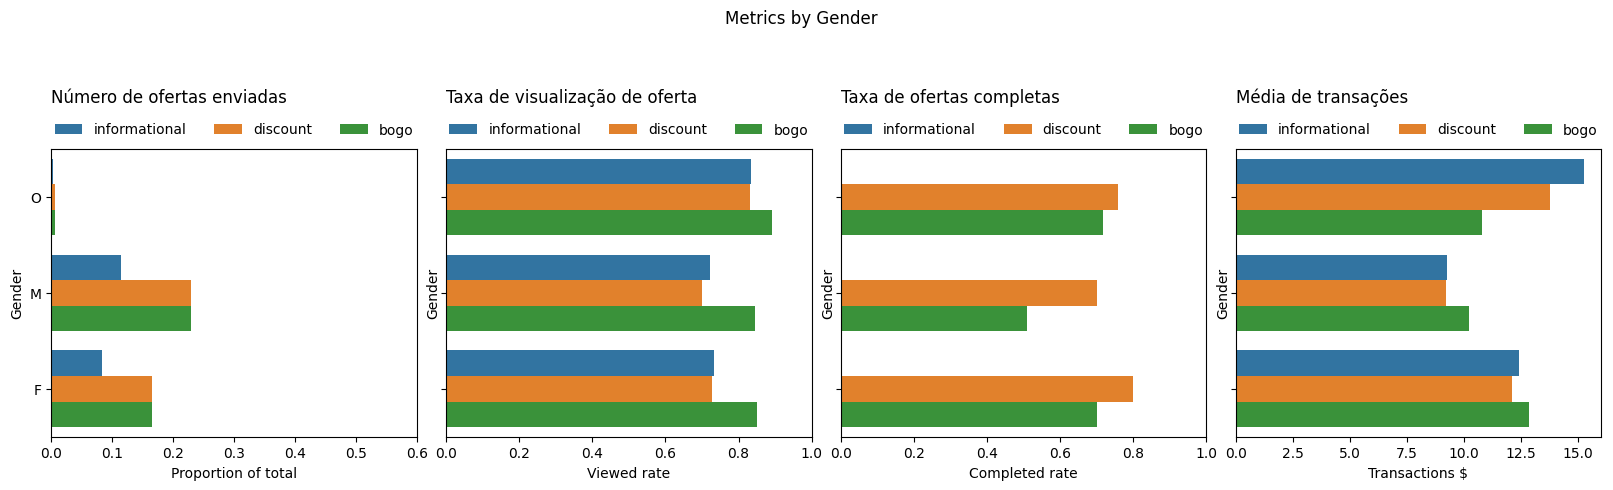

In [23]:
importlib.reload(aux_fun)
df_temp = user_offer_df2.loc[user_offer_df2.gender != 'NI']
aux_fun.plot_grid_metrics(df_temp, ['gender', 'offer_type'], dodge=True)

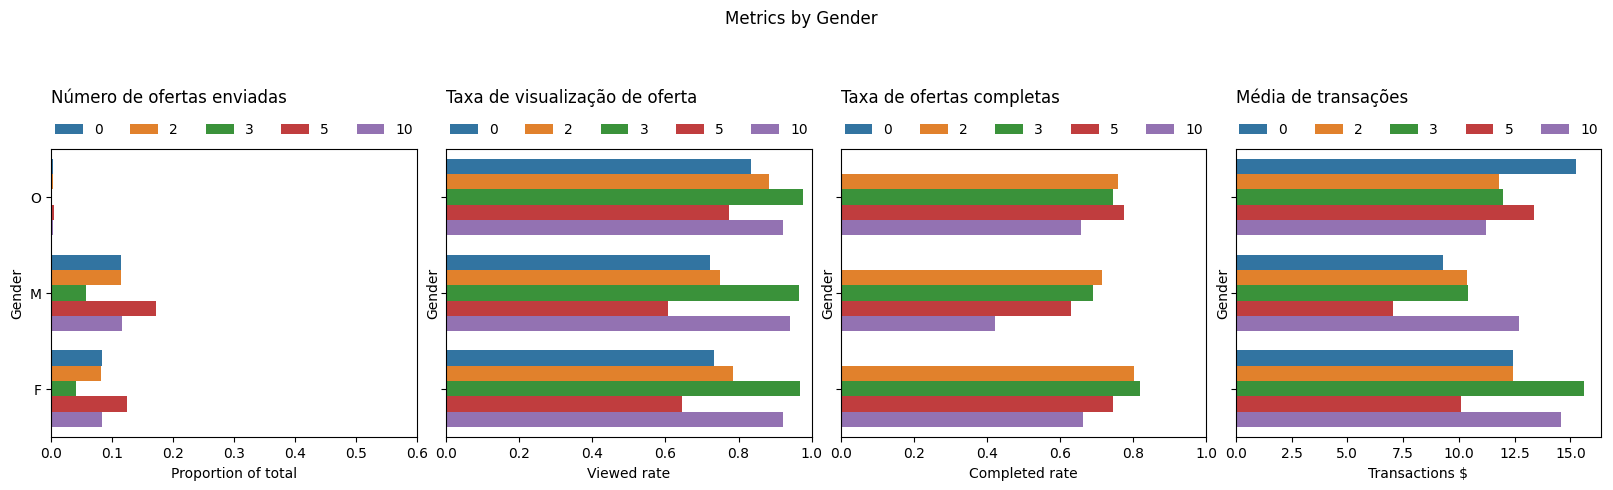

In [24]:
df_temp = user_offer_df2.loc[user_offer_df2.gender != 'NI']
aux_fun.plot_grid_metrics(df_temp, ['gender', 'offer_reward'], dodge=True)

By Age

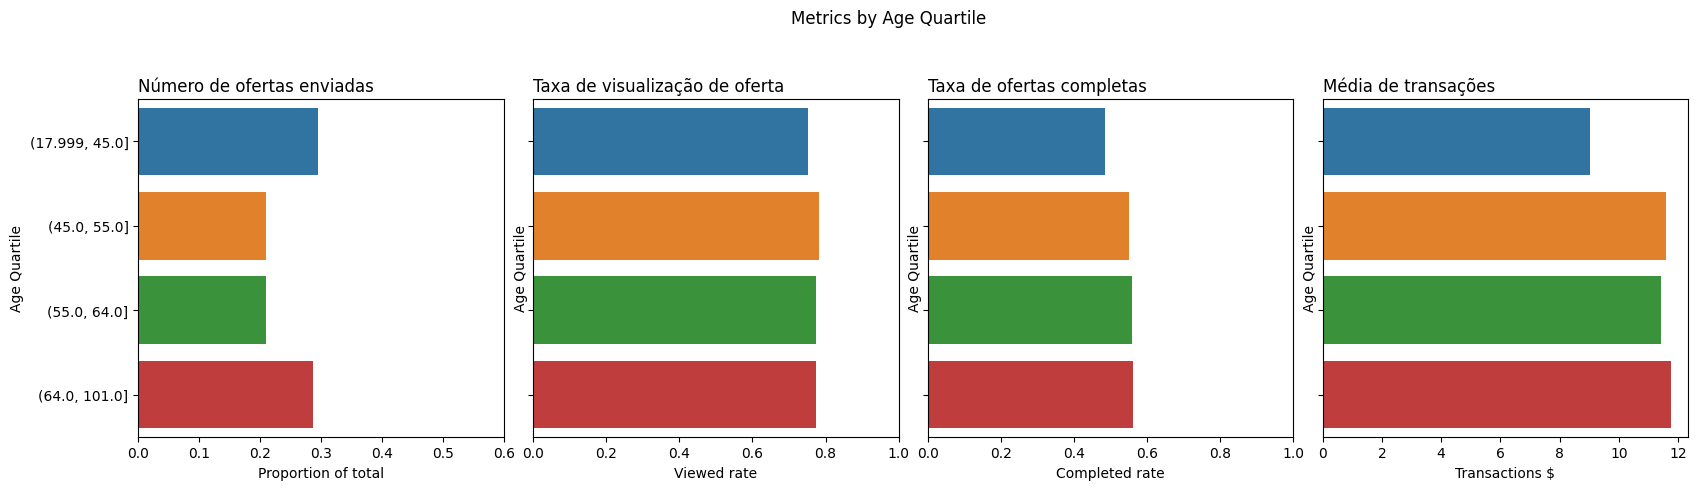

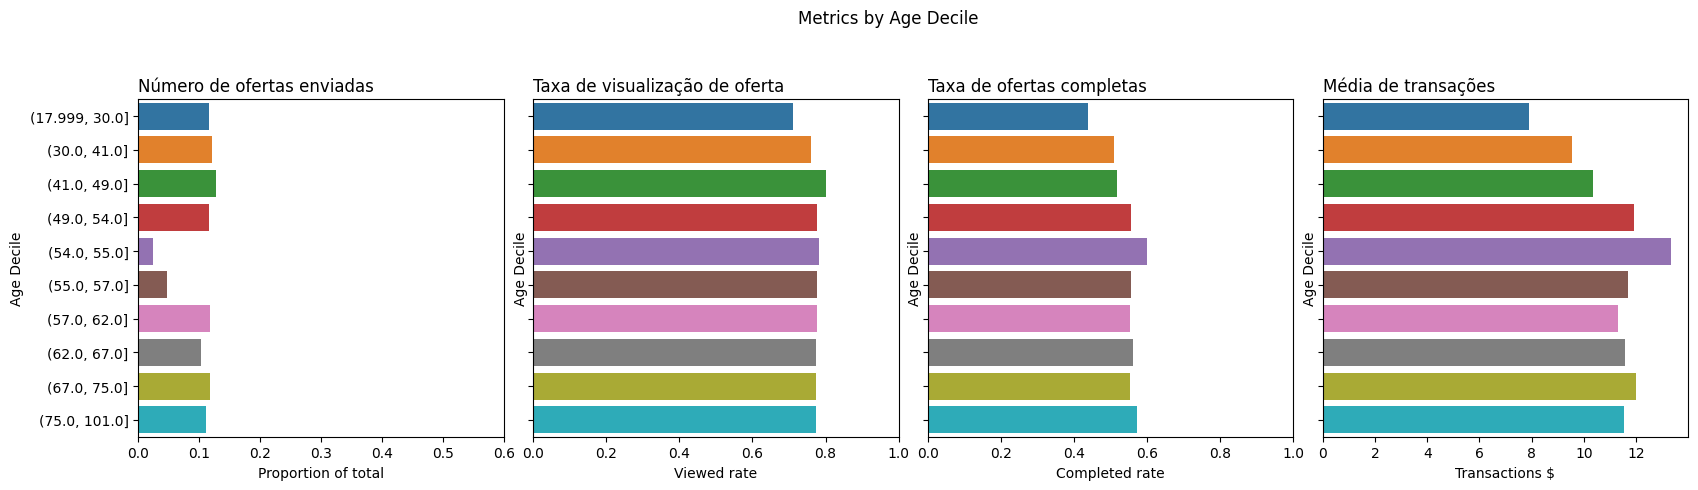

In [25]:
importlib.reload(aux_fun)
df_temp = user_offer_df2.loc[user_offer_df2.gender != 'NI']
aux_fun.plot_grid_metrics(df_temp, 'age_quartile')
aux_fun.plot_grid_metrics(df_temp, 'age_decile')

By Age and Offer Type

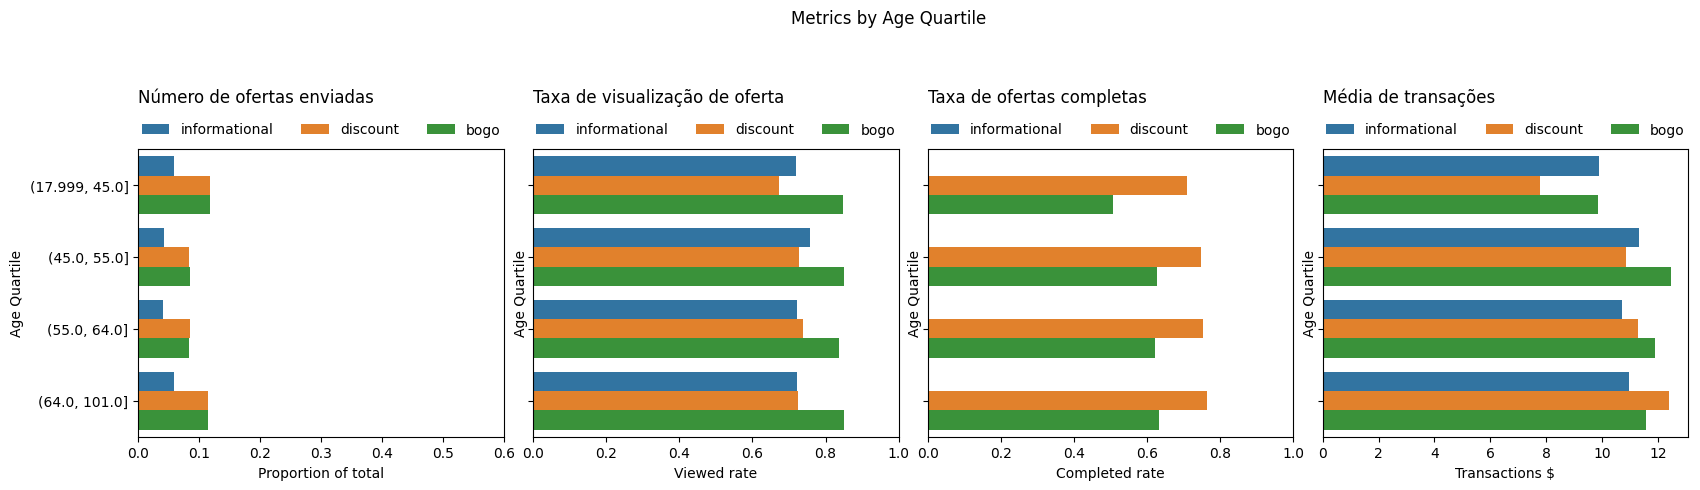

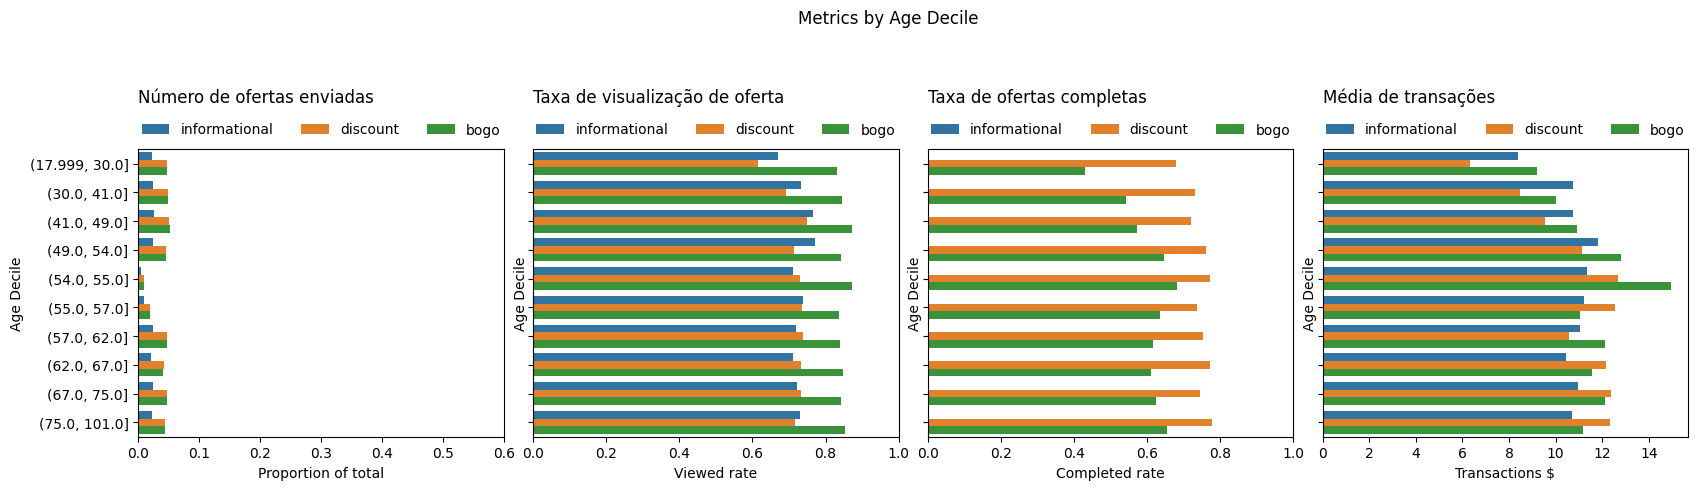

In [26]:
df_temp = user_offer_df2.loc[user_offer_df2.gender != 'NI']
aux_fun.plot_grid_metrics(df_temp, ['age_quartile','offer_type'], dodge=True)
aux_fun.plot_grid_metrics(df_temp, ['age_decile','offer_type'], dodge=True)

By Member Since

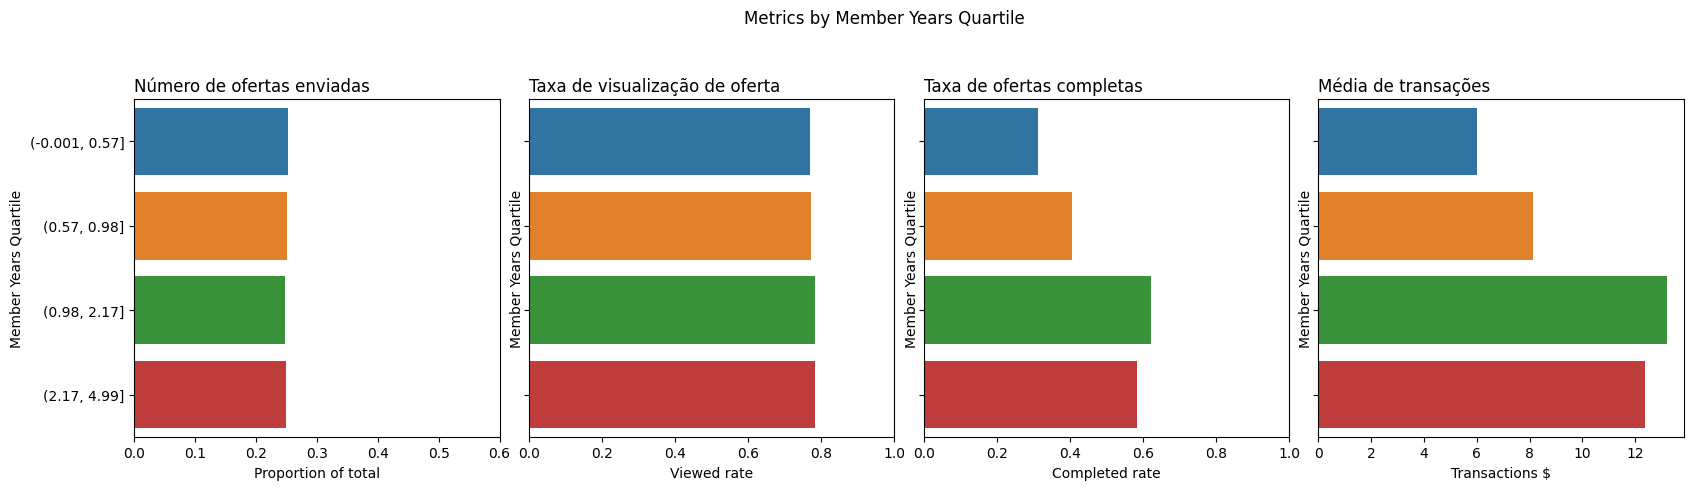

In [27]:
aux_fun.plot_grid_metrics(user_offer_df2, 'member_years_quartile', dodge=True)

By Member Since and Offer_Type

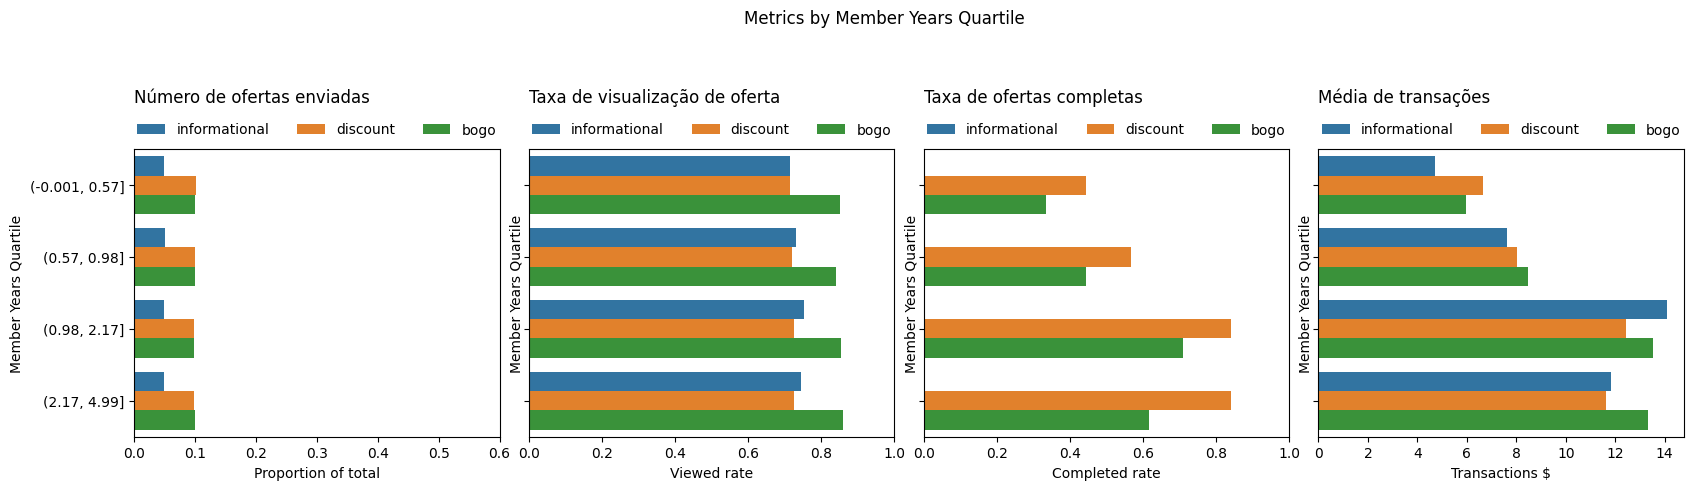

In [28]:
aux_fun.plot_grid_metrics(user_offer_df2, ['member_years_quartile', 'offer_type'], dodge=True)

By Income

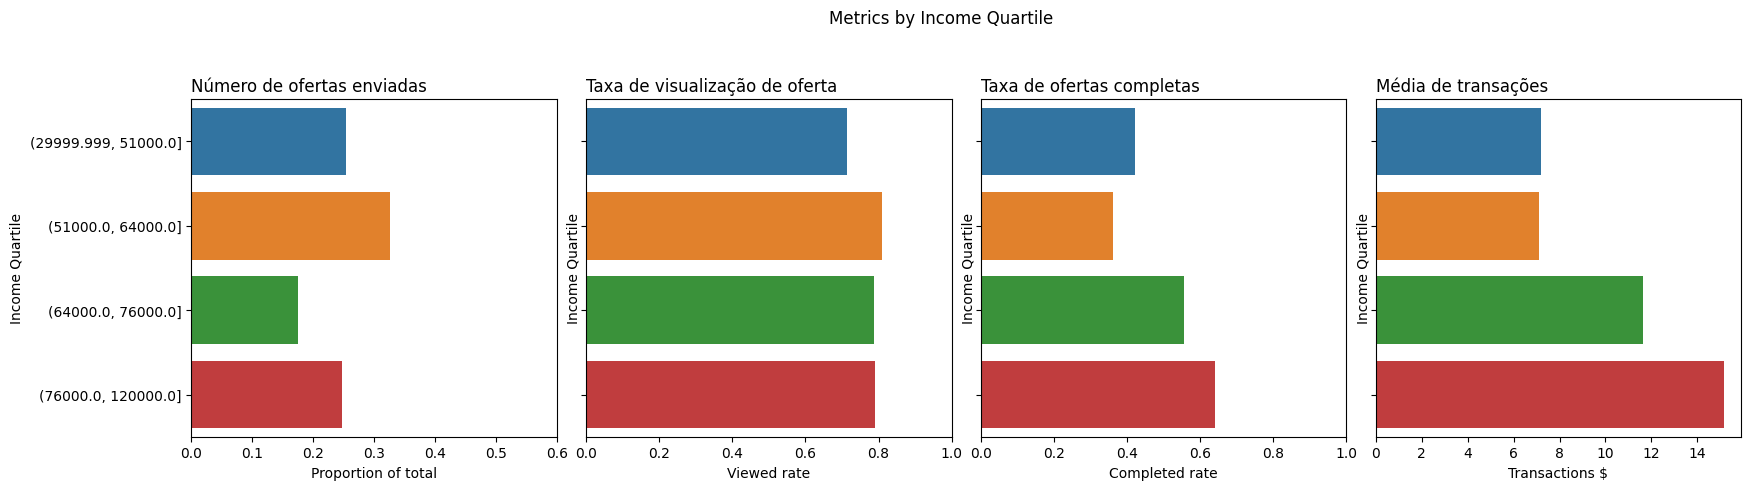

In [29]:
aux_fun.plot_grid_metrics(user_offer_df2, 'income_quartile', dodge=True)

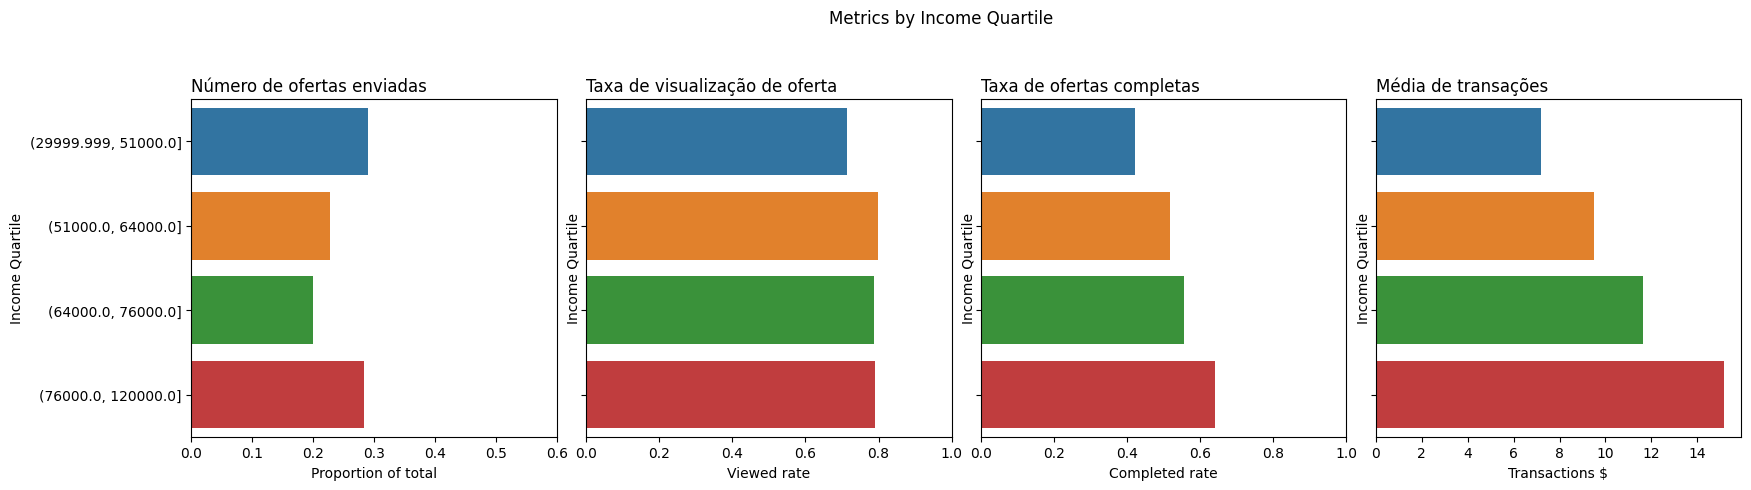

In [30]:
df_temp = user_offer_df2.loc[user_offer_df2.gender != 'NI']
aux_fun.plot_grid_metrics(df_temp, 'income_quartile')

By Income and Offer Proprieties

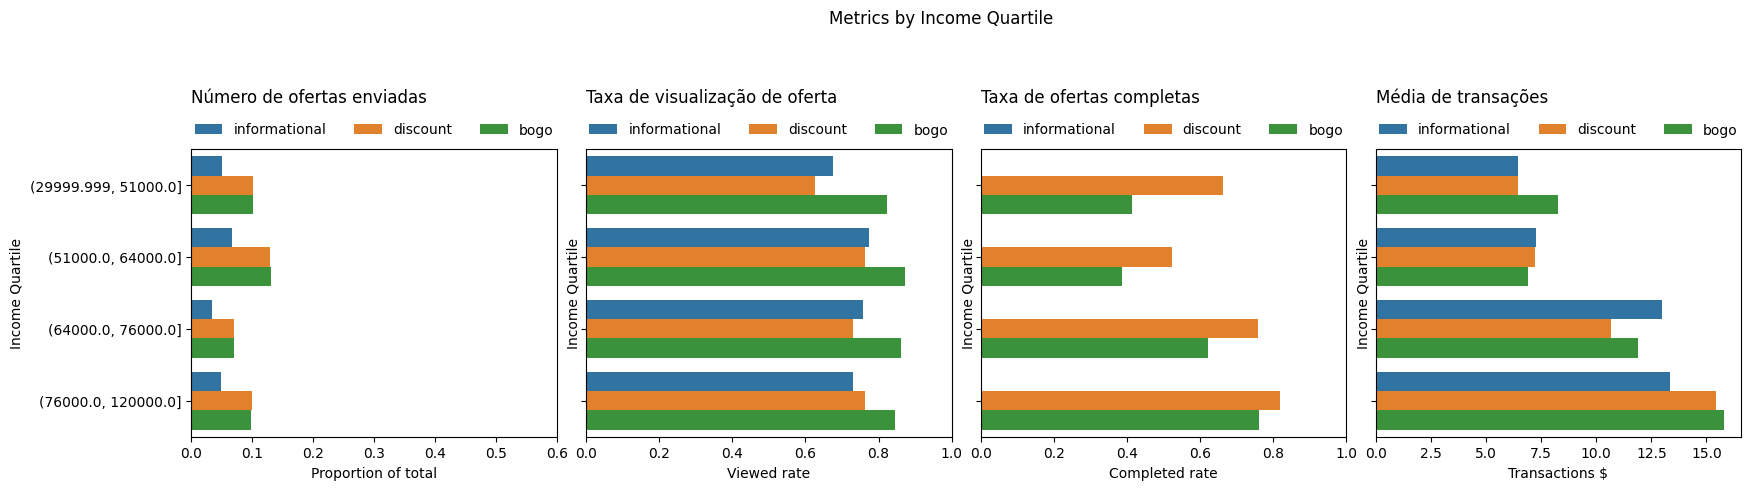

In [31]:
aux_fun.plot_grid_metrics(user_offer_df2, ['income_quartile', 'offer_type'], dodge=True)

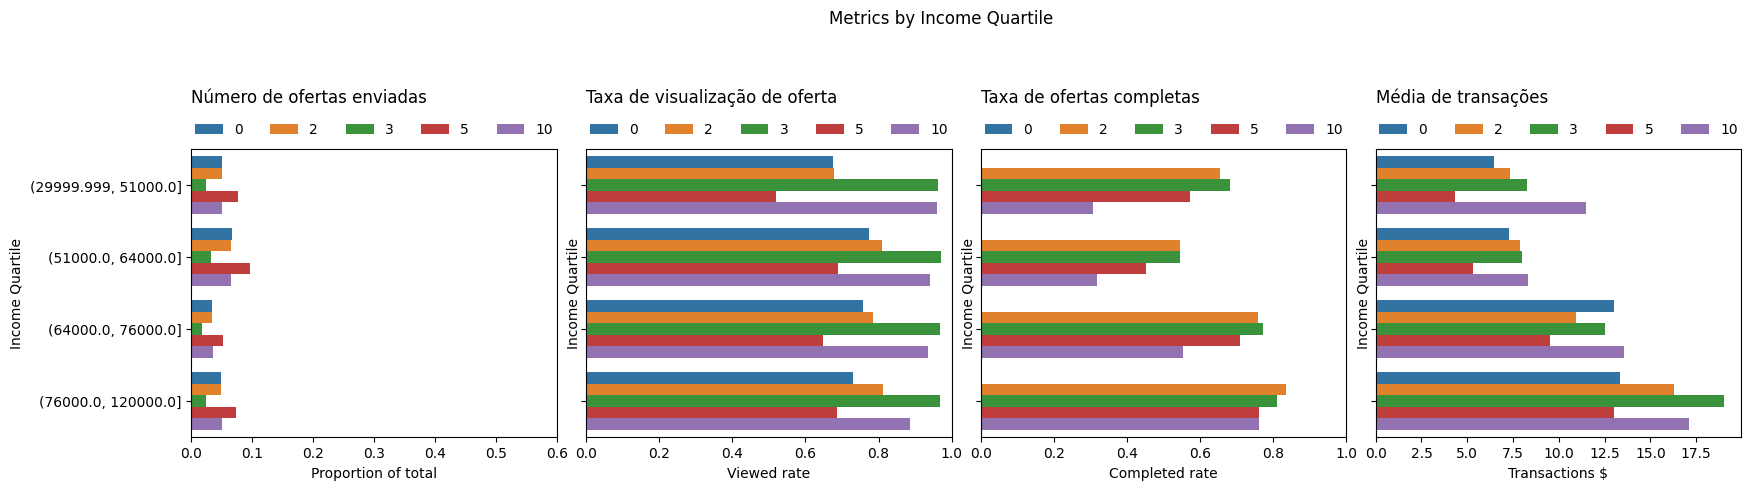

In [32]:
aux_fun.plot_grid_metrics(user_offer_df2, ['income_quartile', 'offer_reward'], dodge=True)

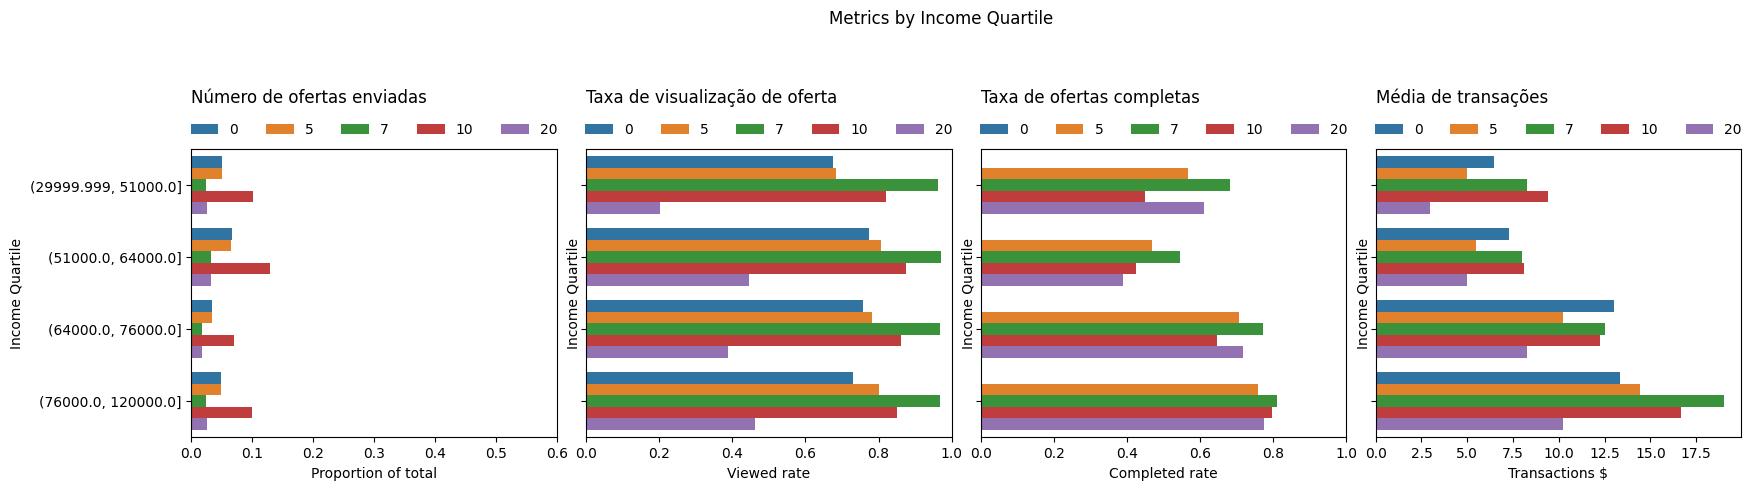

In [33]:
aux_fun.plot_grid_metrics(user_offer_df2, ['income_quartile', 'offer_difficulty'], dodge=True)

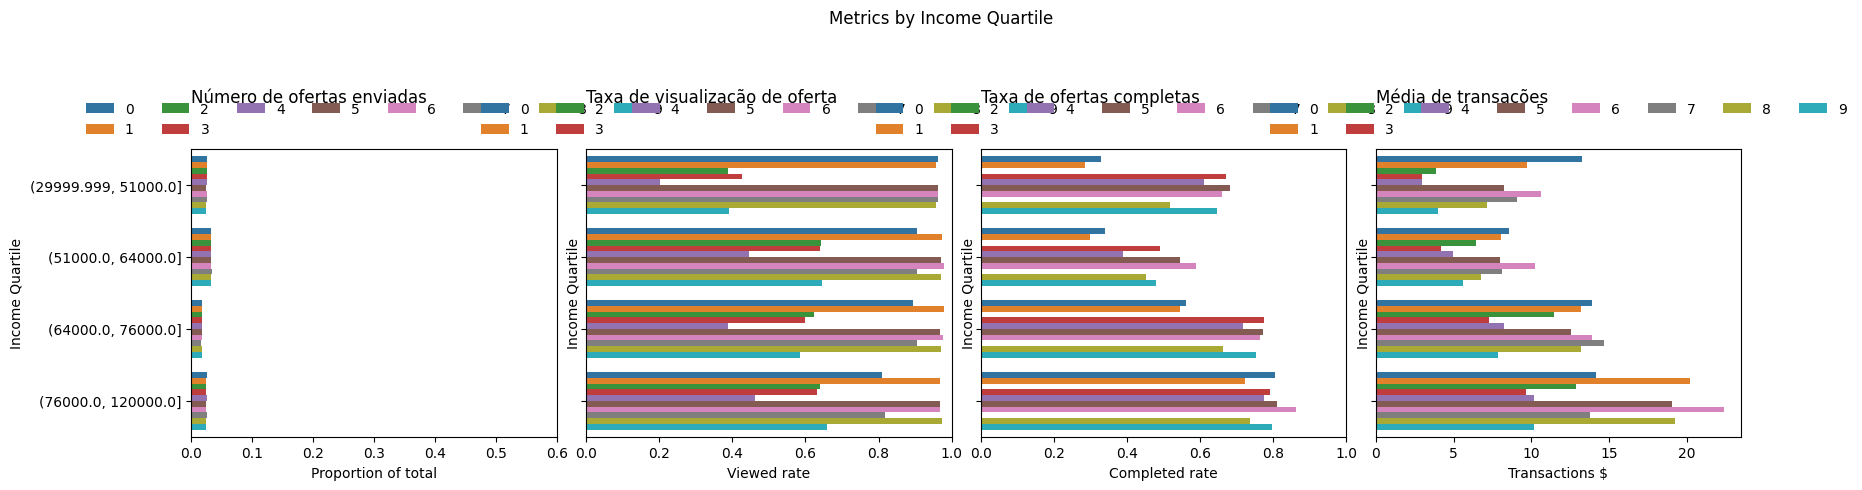

In [34]:
aux_fun.plot_grid_metrics(user_offer_df2, ['income_quartile', 'offer_id'], dodge=True)

In [35]:
portfolio.sort_values('offer_type')

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7


In [36]:
profile

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98
...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,16995,0.14
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,16996,0.04
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,16997,1.50
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,16998,2.39


In [37]:
user_offer_df2

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,...,offer_type,gender,age,income,rela_member_years,age_quartile,age_decile,income_quartile,income_decile,member_years_quartile
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,...,informational,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
1,3,1.0,1.0,19.89,1.0,1.000000,5.0,3,3,5,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
2,0,1.0,1.0,21.72,1.0,1.000000,10.0,3,0,10,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
3,8,1.0,1.0,0.00,1.0,0.000000,5.0,3,8,5,...,bogo,F,75.0,100000.0,1.21,"(64.0, 101.0]","(67.0, 75.0]","(76000.0, 120000.0]","(95000.0, 120000.0]","(0.98, 2.17]"
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,...,informational,NI,55.0,64000.0,0.98,"(45.0, 55.0]","(54.0, 55.0]","(51000.0, 64000.0]","(61000.0, 64000.0]","(0.57, 0.98]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,5,1.0,1.0,14.83,1.0,1.000000,6.0,9950,5,3,...,discount,M,21.0,45000.0,0.44,"(17.999, 45.0]","(17.999, 30.0]","(29999.999, 51000.0]","(38000.0, 47000.0]","(-0.001, 0.57]"
63284,5,1.0,1.0,14.95,1.0,1.000000,3.0,3615,5,3,...,discount,F,63.0,68000.0,0.96,"(55.0, 64.0]","(62.0, 67.0]","(64000.0, 76000.0]","(66000.0, 73000.0]","(0.57, 0.98]"
63285,5,1.0,1.0,30.41,1.0,1.000000,12.0,6691,5,3,...,discount,F,68.0,51000.0,1.15,"(64.0, 101.0]","(67.0, 75.0]","(29999.999, 51000.0]","(47000.0, 54000.0]","(0.98, 2.17]"
63286,5,1.0,1.0,14.25,1.0,1.000000,3.0,15432,5,3,...,discount,M,20.0,70000.0,1.77,"(17.999, 45.0]","(17.999, 30.0]","(64000.0, 76000.0]","(66000.0, 73000.0]","(0.98, 2.17]"


#### Comments

Data are generated by simulation, it is noted that the proportion of the types of offers sent is distributed by 40% for bogo type, 40% for discount and 20% for informational.  

For the same reason, the same must be seen in the distribution by offer id

Exact, the data were generated with the same porportion for all offer ids present in portifolio

For profile data, it is noteworthy that only 6 users have not received any offer.

In [ ]:
np.setdiff1d(profile2['user_id'], user_offer_df2['user_id'])

array([  872,  5425,  5639,  6789, 14763, 15391], dtype=int64)

Because of this, the distribution of offer data are very close to the distribution of profile data

For income data, separates the continuous value into quartiles to check distribuition of offers

TODO CONTINUAR DAQUI

For income, more offers were sent to quartile where there are more people.The income group that least received offers was the third.

For gender

More offers were sent to male, putting with the distribution of this category on the profile base

The first step for an offer to have effect on the user is to view it.  

Visualizations by Type of Offer

In [64]:
# Proportion test between two samples
# The test is one-tailed greater than

list_set = [['bogo', 'informational'], ['bogo', 'discount'], ['informational', 'discount']]

for set_ in list_set:
    aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='offer_type', 
        cat1=set_[0], cat2=set_[1], metric='viewed_rate')

p-value of 0.0. With confidence value of 0.05, bogo and informational distributions are different
p-value of 0.0. With confidence value of 0.05, bogo and discount distributions are different
p-value of 0.002. With confidence value of 0.05, informational and discount distributions are different


Then, statistically, despite close proportions between infromational and discount, the three types of offers have different viewing proportions

Visualizations by offer id

Six offers has visualization fee greater than 80%.Three have a rate greater than 50%.One, the offer with ID 4 has a low view rate.  

Looking at portifolio dataset

In [ ]:
portfolio[['offer_id', 'channels']]

,offer_id,channels
0,0,"[email, mobile, social]"
1,1,"[web, email, mobile, social]"
2,2,"[web, email, mobile]"
3,3,"[web, email, mobile]"
4,4,"[web, email]"
5,5,"[web, email, mobile, social]"
6,6,"[web, email, mobile, social]"
7,7,"[email, mobile, social]"
8,8,"[web, email, mobile, social]"
9,9,"[web, email, mobile]"


Checking on the base of offers, it is noted that the offer with ID 4 has the smallest number of distribution channels, which can be an explanation for the low view rate.

In fact, this happens to the other offers.The more disclosure channels, the higher the visualization fee

Visualizations by ages

Dividing the range of ages in quartiles to see distribution of visualization rate

For the old quarks, the proportions are very similar.  

Statistically checking for two sets of groups

In [ ]:
aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(17.999, 45.0), metric='viewed_rate')

aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(65.0, 101.0), metric='viewed_rate')

p-value of 0.0. With confidence value of 0.05, (45.0, 55.0] and (17.999, 45.0] distributions are different
p-value of 0.0. With confidence value of 0.05, (45.0, 55.0] and (65.0, 101.0] distributions are different


Different from distributions to type of offer, in this case the old quartile groups do not have statistical differences.  
So, all these groups have the same proportion in Viewing Offers

The same analysis for income groups

In [ ]:
aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='income_quartile', 
     cat1=pd.Interval(29999.999, 51000.0), cat2=pd.Interval(51000.0, 64000.0), metric='viewed_rate')

aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='income_quartile', 
     cat1=pd.Interval(76000.0, 120000.0), cat2=pd.Interval(51000.0, 64000.0), metric='viewed_rate')


p-value of 1.0. With confidence value of 0.05, (29999.999, 51000.0] and (51000.0, 64000.0] distributions are equal
p-value of 1.0. With confidence value of 0.05, (76000.0, 120000.0] and (51000.0, 64000.0] distributions are equal


Again, view rates for income groups do not differ

Opening for offer types

Perhaps age and income views vary based on the type of offer

In [ ]:
# Get the types of different offers
offer_types = portfolio2.offer_type.unique()
offer_types

array(['bogo', 'informational', 'discount'], dtype=object)

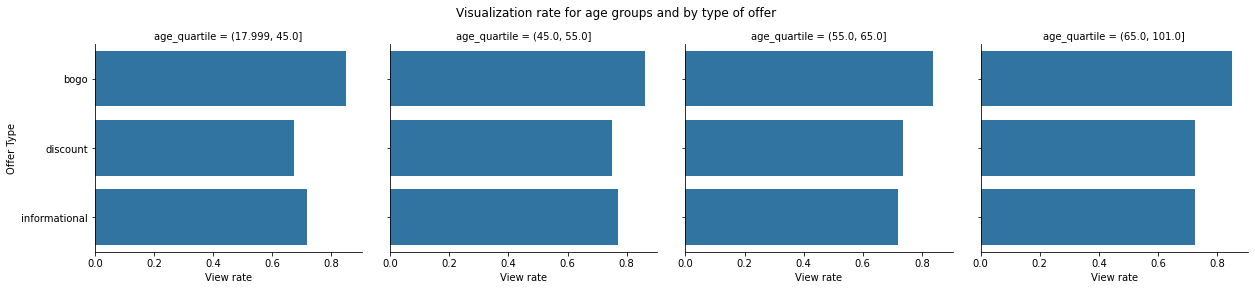

,offer_type,age_quartile,viewed_rate
0,bogo,"(17.999, 45.0]",0.847856
1,bogo,"(45.0, 55.0]",0.860984
2,bogo,"(55.0, 65.0]",0.838852
3,bogo,"(65.0, 101.0]",0.848857
4,discount,"(17.999, 45.0]",0.671880
5,discount,"(45.0, 55.0]",0.751028
6,discount,"(55.0, 65.0]",0.736365
7,discount,"(65.0, 101.0]",0.724396
8,informational,"(17.999, 45.0]",0.718604
9,informational,"(45.0, 55.0]",0.769055


In [ ]:
# Running for each offer type

plot_df = user_offer_df2.groupby(['offer_type', 'age_quartile'], 
    as_index=False)['viewed_rate'].mean().sort_index(ascending=True)

# Ploting in grid
g = sns.FacetGrid(data=plot_df, col='age_quartile', sharex=True)
g.map_dataframe(sns.barplot, y='offer_type', x='viewed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for age groups and by type of offer')
g.set_xlabels('View rate')
g.set_ylabels('Offer Type')

fig = plt.gcf()

fig.set_size_inches(18,4)
plt.show()

plot_df

Nothing different from the porportions again. High values are for BOGO offers, which had already been seen previously.  

For income quartiles

Same situation, without any big tendecy.  

A point that can be highlighted is that the discount type has lower proportion for the first quatis (both age and income). In other groups, the proportions follow the general trend already seen between types of offers.

If well observe, rates are many similar to age groupings and income. This is related to the distribution of data.People from the first quartile old are also more present in the quartile of income

In [ ]:
user_offer_df2.groupby(['age_quartile', 'income_quartile']).agg(count=('income_quartile', 'count'))

count
age_quartile   income_quartile            
(17.999, 45.0] (29999.999, 51000.0]   7300
               (51000.0, 64000.0]     4525
               (64000.0, 76000.0]     3299
               (76000.0, 120000.0]    1114
(45.0, 55.0]   (29999.999, 51000.0]   2726
               (51000.0, 64000.0]    10553
               (64000.0, 76000.0]     2433
               (76000.0, 120000.0]    3901
(55.0, 65.0]   (29999.999, 51000.0]   2771
               (51000.0, 64000.0]     2499
               (64000.0, 76000.0]     2465
               (76000.0, 120000.0]    4820
(65.0, 101.0]  (29999.999, 51000.0]   3183
               (51000.0, 64000.0]     2989
               (64000.0, 76000.0]     2829
               (76000.0, 120000.0]    5739

##### 3. Complete Rate

Após recebida, a oferta pode ser visualizada ou não.  
Para completar uma oferta não é necessário olhar para ela.  

Completation by Type of Offer

What looks like is that buy-one get one offers has a slightly larger viewing fee compared to the other two.

Fact that proportions are not really so far from one another
However, it is possible to test whether these proportions are statistically different with a test of proprotions between independent samples (and considering that they are normal).

In [ ]:
# Proportion test between two samples
# The test is one-tailed greater than

list_set = [['discount', 'bogo']]

analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

for set_ in list_set:
    aux_fun.test_proportions_in_dataframe(df=analisys_df, column='offer_type', 
        cat1=set_[0], cat2=set_[1], metric='completed_rate')

p-value of 0.0. With confidence value of 0.05, discount and bogo distributions are different


Como visto, a taxa de completação de ofertas é maior para ofertas do tipo discount, validado estatisticamente.  

Assim, quando comparado com bogo, pode-se dizer que as pessoas usam mais os discontos que as ofertas de comprar um e levar outro


Complete by offer id

Ofertas 7 e 2 são informational, logo, não tem completação.  
Para as demais, nota-se que a oferta 6 e 5 têm maior completação. 
A oferta 1 tem uma boa taxa de visualição, mas não foi tão completada quanto as demais.  
A oferta 8 tinha uma taxa de visualização alta, porém, mostrou taxa de completação baixa. 

A razão para isso talvez seja melhor vista abaixo

Pelo que é visualizado, as ofertas de tipo disconto tem realmente maiores taxa de completação em comparação com as ofertas do tipo bogo. 

Assim, para os usuários, as ofertas de disconto parecem mais chamativas que as de oferta de ganhar outro de graça

Completation by ages

Dividing the range of ages in quartiles to see distribution of visualization rate

Na separação por grupos de idades, nota-se que as diferenças estatísticas na visualização de ofertas também se reflete na taxa de completação.  

Grupos

In [ ]:
analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(17.999, 45.0), metric='completed_rate')

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(65.0, 101.0), metric='completed_rate')

p-value of 1.0. With confidence value of 0.05, (45.0, 55.0] and (17.999, 45.0] distributions are equal
p-value of 1.0. With confidence value of 0.05, (45.0, 55.0] and (65.0, 101.0] distributions are equal


Different from distributions to type of offer, in this case the old quartile groups do not have statistical differences.  
So, all these groups have the same proportion in Viewing Offers

The same analysis for income groups

In [ ]:
analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='income_quartile', 
     cat1=pd.Interval(29999.999, 51000.0), cat2=pd.Interval(51000.0, 64000.0), metric='completed_rate')

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='income_quartile', 
     cat1=pd.Interval(76000.0, 120000.0), cat2=pd.Interval(51000.0, 64000.0), metric='completed_rate')


p-value of 0.0. With confidence value of 0.05, (29999.999, 51000.0] and (51000.0, 64000.0] distributions are different
p-value of 0.0. With confidence value of 0.05, (76000.0, 120000.0] and (51000.0, 64000.0] distributions are different


Estatisticamente os valores diferem.  

Observa-se que para as rendas de valores maiores (último quartil), as taxas de completação são maiores comparadas aos outros grupos, enquanto as taxas de visualização eram muito próximas.

Opening for offer types

Perhaps age and income views vary based on the type of offer

In [ ]:
# Get the types of different offers
offer_types = portfolio2.offer_type.unique()
offer_types

array(['bogo', 'informational', 'discount'], dtype=object)

Em todos os grupos, nota-se os valores mais altos em disconto, ao invés de bogo

For income quartiles

Para o grupo com maior taxa de compeltação (último quartil de renda), tanto bogo quando disconto é visto por igual.  

Já para outros grupos, nota-se que o grupo do primeiro quartil tem maior taxa de completar discontos ao invés de bogo.

##### 4. Transactions

Transações realizadas pelos usuários são de dois tipos, uma natural e outra influenciada por uma oferta.  

A transações influenciadas por ofertas são o alvo dessa análise.

Mean transactions by offer type

Transações por offer ID

In [ ]:
import functions.functions as aux_fun
importlib.reload(aux_fun)

aux_fun.test_means_in_dataframe(df=user_offer_df2, column='offer_id_rec', 
    cat1=3, cat2=4, metric='tra_offer_infl')

p-value of 0.097. With confidence value of 0.05, means of 3 (18.13) and 4 (16.65) are equal


In [ ]:
portfolio.sort_values('offer_type')

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7


Transaction by ages

O grupo de 45 a 55 anos tem menor taxa de completação e menores gastos gerais devido as ofertas

In [ ]:
aux_fun.test_means_in_dataframe(df=user_offer_df2, column='income_quartile', 
    cat1=pd.Interval(51000,64000), cat2=pd.Interval(29999.999, 51000.0), metric='tra_offer_infl')

p-value of 0.09. With confidence value of 0.05, means of (51000, 64000] (16.06) and (29999.999, 51000.0] (15.38) are equal


Para as transações por grupo de renda, nota-se que segue o racional da renda, quanto maior, maior a quantida de transações feita por aquele grupo.

Usuários com mais tempo de membro costumam gastar mais devido a ofertas

In [ ]:
aux_fun.test_means_in_dataframe(df=user_offer_df2, column='member_time_quartile', 
    cat1=pd.Interval(208.0, 358.0), cat2=pd.Interval(358.0, 791.75), metric='tra_offer_infl')

p-value of 0.0. With confidence value of 0.05, means of (208.0, 358.0] (18.28) and (358.0, 791.75] (34.89) are are different


In [ ]:
aux_fun.test_means_in_dataframe(df=user_offer_df2, column='gender', 
    cat1='F', cat2='O', metric='tra_offer_infl')

p-value of 0.706. With confidence value of 0.05, means of F (31.77) and O (32.66) are equal


Em média, mulhes e outros gastam mais após ofertas que homens